# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [1]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

  Preparing metadata (setup.py) ... done


We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [2]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [3]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [4]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:19.2
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmpwtu3yov7:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention

Model parameters are replicated on each device for faster inference.

In [5]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [6]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [7]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [8]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:20.8


Let's define some text prompts.

In [9]:
prompts = [
    "avocado flying in the space",
]

Note: we could use the same prompt multiple times for faster inference.

In [10]:
tokenized_prompts = processor(prompts)

Finally we replicate the prompts onto each device.

In [11]:
tokenized_prompt = replicate(tokenized_prompts)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [12]:
# number of predictions per prompt
n_predictions = 4

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

Prompts: ['avocado flying in the space']



  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


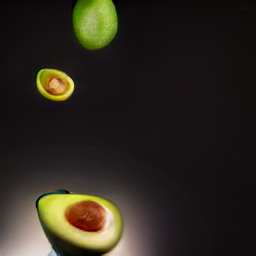

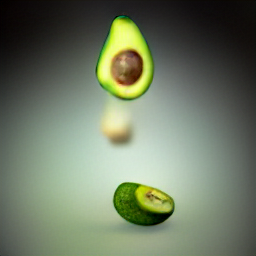

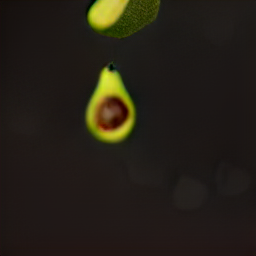

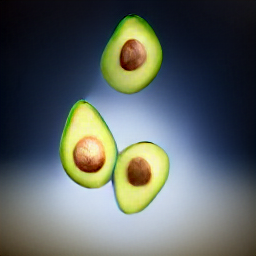

In [13]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()

## 🏅 Optional: Rank images by CLIP score

We can rank images according to CLIP.

**Note: your session may crash if you don't have a subscription to Colab Pro.**

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=prompts * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

# organize scores per prompt
p = len(prompts)
logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()

Let's now display images ranked by CLIP score.

In [ ]:
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}\n")
    for idx in logits[i].argsort()[::-1]:
        display(images[idx * p + i])
        print(f"Score: {jnp.asarray(logits[i][idx], dtype=jnp.float32):.2f}\n")
    print()

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = "dalle-mini-tables-colab"
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    if logits is not None:
        idxs = logits[i].argsort()[::-1]
        tmp_imgs = images[i :: len(prompts)]
        tmp_imgs = [tmp_imgs[idx] for idx in idxs]
    else:
        tmp_imgs = images[i :: len(prompts)]

    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for img in tmp_imgs])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

Click on the link above to check out your generated images.